In [2]:
import numpy as np
import pickle
import os
import importlib
import matplotlib.pyplot as plt
import my_bite_detection_utils as bdu

In [3]:
#importlib.reload(mtu)
importlib.reload(bdu)

<module 'my_bite_detection_utils' from 'C:\\ASM\\Dropbox\\Developments\\Jupyter\\Eating\\bite_detection\\my_bite_detection_utils.py'>

In [4]:
with open('C:/ASM/DevData/eating/data/steven_uva_lab_data_combined.pkl', 'rb') as file:
    ds = pickle.load(file)

In [5]:
x_th = 0
min_bite_interval = 2*16
window_size = 6*16
max_annot_distance = 3*16

sub_sess_mps, sub_sess_annots,  = np.empty((0, 3), dtype=int), np.empty((0, 4), dtype=int)
mp_covs, annot_covs = np.empty((0, 5), dtype=int), np.empty((0, 5), dtype=int)
x_var_mps = np.empty((0, 2))
x_annots = np.empty((0, 3))
var_annots = np.empty((0, 3))
grav_accel_gyro_vals = np.empty((0, window_size, 9))

total_duration = 0
window_duration = 0

for subject in range(len(ds)):
    for sess in range(len(ds[subject])):
        print("Subejct, sess: ", subject, sess)
        data = ds[subject][sess]['data']
        annots = ds[subject][sess]['annots']
        
        mps = bdu.find_min_points_by_xth(data[:, 1], x_th, min_bite_interval)
        mps = bdu.remove_min_points_at_boundary(mps, len(data), window_size//2)
        total_duration += data[-1,0]
        window_duration += len(mps)*window_size/16
        
        
        ssm = np.zeros((len(mps), 3))
        ssm[:, 0] = ssm[:, 0] + subject
        ssm[:, 1] = ssm[:, 1] + sess
        ssm[:, 2] = mps
        sub_sess_mps = np.concatenate((sub_sess_mps, ssm), axis=0)        
        
        ssa = np.zeros((len(annots), 4))
        ssa[:, 0] = ssa[:, 0] + subject
        ssa[:, 1] = ssa[:, 1] + sess
        ssa[:, 2:] = annots
        sub_sess_annots = np.concatenate((sub_sess_annots, ssa), axis=0)        
                
        mp_cov, annot_cov = bdu.get_coverage_stat(mps, annots, max_distance=max_annot_distance)
        mp_covs = np.concatenate((mp_covs, mp_cov), axis=0)
        annot_covs = np.concatenate((annot_covs, annot_cov), axis=0)         
                
        xv = np.zeros((len(mps), 2))        
        xv[:, 0] = data[mps, 1]        #grav x        
        print(np.sum(xv[:, 0]>1))
        w = bdu.get_windows(data[:, 1:], mps, window_size)        
        xv[:, 1] = bdu.get_variance(w, 3, 5) #accel var        
        x_var_mps = np.concatenate((x_var_mps, xv), axis=0)
        
        grav_accel_gyro_vals = np.concatenate((grav_accel_gyro_vals, w), axis=0)
        
        
        ac = np.copy(annot_cov)
        ac = ac[:, :3]        
        flags = ac<0
        ac[flags] = 0                
        
        xa = np.zeros((len(annots), 3))        
        xa[:, 0] = data[mps[ac[:, 0]], 1]
        xa[:, 1] = data[mps[ac[:, 1]], 1]
        xa[:, 2] = data[mps[ac[:, 2]], 1]
        xa[flags] = 1
        x_annots = np.concatenate((x_annots, xa), axis=0)
        
        va = np.zeros((len(annots), 3))
        va[:,0] = xv[ac[:,0], 1]
        va[:,1] = xv[ac[:,1], 1]
        va[:,2] = xv[ac[:,2], 1]
        va[flags] = -1
        var_annots = np.concatenate((var_annots, va), axis=0)                

Subejct, sess:  0 0
0
Subejct, sess:  1 0
0
Subejct, sess:  2 0
0
Subejct, sess:  2 1
0
Subejct, sess:  3 0
0
Subejct, sess:  3 1
0
Subejct, sess:  4 0
0
Subejct, sess:  4 1
0
Subejct, sess:  5 0
0
Subejct, sess:  5 1
0
Subejct, sess:  6 0
0
Subejct, sess:  6 1
0
Subejct, sess:  7 0
0
Subejct, sess:  8 0
0
Subejct, sess:  9 0
0
Subejct, sess:  10 0
0
Subejct, sess:  11 0
0
Subejct, sess:  12 0
0
Subejct, sess:  13 0
0
Subejct, sess:  14 0
0
Subejct, sess:  15 0
0
Subejct, sess:  16 0
0
Subejct, sess:  17 0
0
Subejct, sess:  18 0
0
Subejct, sess:  19 0
0
Subejct, sess:  20 0
0
Subejct, sess:  21 0
0
Subejct, sess:  21 1
0
Subejct, sess:  22 0
0
Subejct, sess:  22 1
0
Subejct, sess:  22 2
0
Subejct, sess:  22 3
0
Subejct, sess:  23 0
0
Subejct, sess:  23 1
0
Subejct, sess:  24 0
0
Subejct, sess:  24 1
0
Subejct, sess:  25 0
0
Subejct, sess:  25 1
0
Subejct, sess:  25 2
0
Subejct, sess:  25 3
0
Subejct, sess:  26 0
0
Subejct, sess:  26 1
0
Subejct, sess:  26 2
0
Subejct, sess:  26 3
0
Sub

In [6]:
print(len(sub_sess_mps))
print(total_duration, window_duration, len(sub_sess_mps)*6, 100*window_duration/total_duration)


52521
306710.875 315126.0 315126 102.74366697952918


In [7]:
#Windows
total, neg, bite, sip = len(mp_covs), np.sum(mp_covs[:,0]==0), np.sum(mp_covs[:,0]==1), np.sum(mp_covs[:,0]==2)
print("Windows total, neg, bite, sip: ", total, neg, bite, sip)

Windows total, neg, bite, sip:  52521 47903 3609 1009


In [6]:
print(np.sum(mp_covs>=1, axis=0))

[4618  321   21    0    0]


In [7]:
#same window covered by different types of annots (both bite and sip)
cond = (mp_covs[:,0]>=1) & (mp_covs[:,1]>=1) & (mp_covs[:,0]!=mp_covs[:,1])
print(np.sum(cond))
#sub_sess_mps[cond]

9


In [8]:
#annots
a = sub_sess_annots[:, 3]
total, bite, sip = len(annot_covs), np.sum(a==1), np.sum(a==2)
bite_missed = np.sum((a==1) & (annot_covs[:, 0]<0))
sip_missed = np.sum((a==2) & (annot_covs[:, 0]<0))
print("GT Annots total, bite, sip: ", total, bite, sip)
print("Annots missed bite, sip   : ", bite_missed, sip_missed)

GT Annots total, bite, sip:  3842 2955 887
Annots missed bite, sip   :  32 32


In [9]:
print(np.sum(annot_covs>=0, axis=0))

[3778 1110   72    0    0]


In [10]:
print(np.sum(x_annots<=-0, axis=0))

[3778 1110   72]


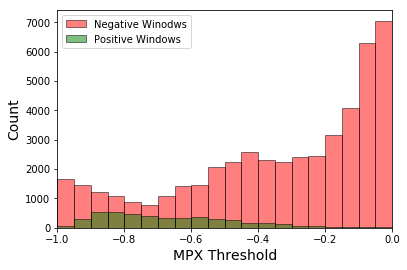

-1.0 0
-0.95 1668
-0.8999999999999999 3124
-0.8499999999999999 4353
-0.7999999999999998 5440
-0.7499999999999998 6327
-0.6999999999999997 7094
-0.6499999999999997 8184
-0.5999999999999996 9603
-0.5499999999999996 11052
-0.49999999999999956 13105
-0.4499999999999995 15346
-0.39999999999999947 17918
-0.3499999999999994 20222
-0.2999999999999994 22474
-0.24999999999999933 24874
-0.1999999999999993 27335
-0.14999999999999925 30507
-0.0999999999999992 34572
-0.049999999999999156 40853
8.881784197001252e-16 47903
(21, 2)


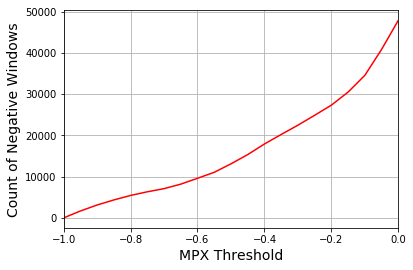

-1.0 0
-0.95 55
-0.8999999999999999 339
-0.8499999999999999 893
-0.7999999999999998 1432
-0.7499999999999998 1906
-0.6999999999999997 2305
-0.6499999999999997 2645
-0.5999999999999996 2985
-0.5499999999999996 3348
-0.49999999999999956 3660
-0.4499999999999995 3915
-0.39999999999999947 4090
-0.3499999999999994 4263
-0.2999999999999994 4396
-0.24999999999999933 4465
-0.1999999999999993 4518
-0.14999999999999925 4556
-0.0999999999999992 4577
-0.049999999999999156 4599
8.881784197001252e-16 4618
(21, 2)


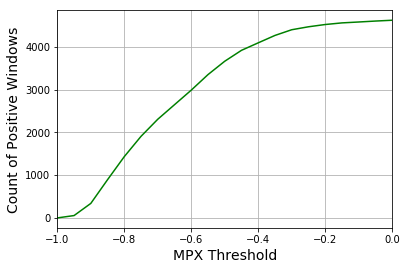

In [19]:
neg_cond = mp_covs[:, 0]==0
pos_cond = mp_covs[:, 0]>0

x_neg = x_var_mps[neg_cond, 0]
x_pos = x_var_mps[pos_cond, 0]
bins = np.linspace(-1, 0, 21)
plt.hist(x_neg, bins, alpha=0.5, label='Negative Winodws', color='red', edgecolor='black')
plt.hist(x_pos, bins, alpha=0.5, label='Positive Windows', color='green', edgecolor='black')
plt.xlim([-1.0,0])
plt.ylabel('Count', fontsize=14)
plt.xlabel('MPX Threshold', fontsize=14)
plt.legend(loc='upper left')
#plt.grid(True)
plt.show()

res = []
for xth in np.arange(-1, 0.01, 0.05):
    #xth = int(xth*100)/100
    count = np.sum(x_neg<=xth)
    print(xth, count)
    res.append([xth, count])
res = np.array(res)
print(res.shape)
plt.plot(res[:, 0], res[:, 1], color='red')
plt.xlim([-1,0])
plt.ylabel('Count of Negative Windows', fontsize=14)
plt.xlabel('MPX Threshold', fontsize=14)
plt.grid(True)
plt.show()

res = []
for xth in np.arange(-1, 0.01, 0.05):
    #xth = int(xth*100)/100
    count = np.sum(x_pos<=xth)
    print(xth, count)
    res.append([xth, count])
res = np.array(res)
print(res.shape)
plt.plot(res[:, 0], res[:, 1], color='green')
plt.xlim([-1,0])
plt.ylabel('Count of Positive Windows', fontsize=14)
plt.xlabel('MPX Threshold', fontsize=14)
plt.grid(True)
plt.show()
    
    


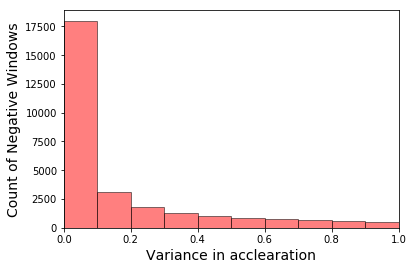

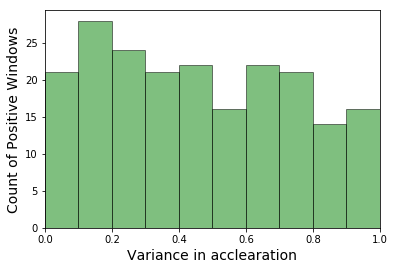

0.0 47903
0.1 29906
0.2 26814
0.3 25008
0.4 23693
0.5 22667
0.6 21806
0.7 21078
0.8 20405
0.9 19856
1.0 19345
1.1 18892
1.2 18475
1.3 18139
1.4 17810
1.5 17539
1.6 17259
1.7 16979
1.8 16726
1.9 16492
2.0 16243
2.1 16015
2.2 15834
2.3 15662
2.4 15483
2.5 15300
2.6 15146
2.7 15001
2.8 14850
2.9 14700
3.0 14548
3.1 14418
3.2 14284
3.3 14150
3.4 14032
3.5 13923
3.6 13799
3.7 13686
3.8 13578
3.9 13466
4.0 13371
4.1 13277
4.2 13190
4.3 13096
4.4 12988
4.5 12882
4.6 12806
4.7 12727
4.8 12637
4.9 12556
(50, 2)


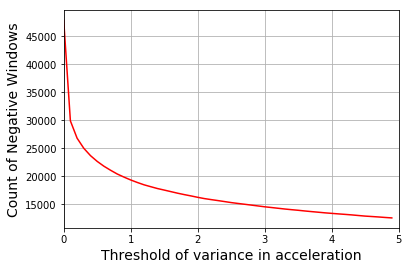

0.0 4618
0.1 4597
0.2 4569
0.3 4545
0.4 4524
0.5 4502
0.6 4486
0.7 4464
0.8 4443
0.9 4429
1.0 4413
1.1 4393
1.2 4373
1.3 4355
1.4 4340
1.5 4314
1.6 4297
1.7 4273
1.8 4259
1.9 4243
2.0 4221
2.1 4205
2.2 4188
2.3 4175
2.4 4158
2.5 4142
2.6 4127
2.7 4110
2.8 4100
2.9 4086
3.0 4068
3.1 4051
3.2 4040
3.3 4020
3.4 4006
3.5 3991
3.6 3966
3.7 3953
3.8 3937
3.9 3924
4.0 3906
4.1 3894
4.2 3882
4.3 3864
4.4 3855
4.5 3843
4.6 3838
4.7 3828
4.8 3820
4.9 3807
(50, 2)


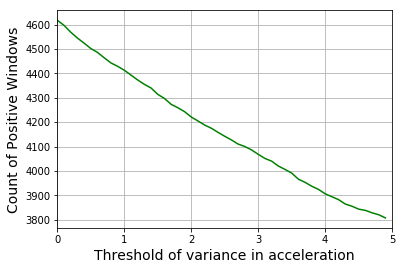

In [18]:
var_neg = x_var_mps[neg_cond, 1]   
var_pos = x_var_mps[pos_cond, 1]
bins = np.linspace(0, 2, 21)

plt.hist(var_neg, bins, alpha=0.5, color='red', edgecolor='black')
plt.xlim([0, 1])
plt.ylabel('Count of Negative Windows', fontsize=14)
plt.xlabel('Variance in acclearation', fontsize=14)
#plt.grid(True)
plt.show()

plt.hist(var_pos, bins, alpha=0.5, color='green', edgecolor='black')
plt.xlim([0, 1])
plt.ylabel('Count of Positive Windows', fontsize=14)
plt.xlabel('Variance in acclearation', fontsize=14)
#plt.grid(True)
plt.show()


max_var = 5
res = []
for varth in np.arange(0, max_var, 0.1):
    varth = int(varth*100)/100
    count = np.sum(var_neg>=varth)
    print(varth, count)
    res.append([varth, count])
res = np.array(res)
print(res.shape)
plt.plot(res[:, 0], res[:, 1], color='red')
plt.xlim([0, max_var])
plt.ylabel('Count of Negative Windows', fontsize=14)
plt.xlabel('Threshold of variance in acceleration', fontsize=14)
plt.grid(True)
plt.show()

res = []
for varth in np.arange(0, max_var, 0.1):
    varth = int(varth*100)/100
    count = np.sum(var_pos>=varth)
    print(varth, count)
    res.append([varth, count])
res = np.array(res)
print(res.shape)
plt.plot(res[:, 0], res[:, 1], color='green')
plt.xlim([0, max_var])
plt.ylabel('Count of Positive Windows', fontsize=14)
plt.xlabel('Threshold of variance in acceleration', fontsize=14)
plt.grid(True)
plt.show()

[0.0, 64, 1.665799062988027]
[-0.05, 73, 1.9000520562207184]
[-0.1, 80, 2.082248828735034]
[-0.15000000000000002, 81, 2.108276939094222]
[-0.2, 93, 2.420614263404477]
[-0.25, 97, 2.5247267048412287]
[-0.30000000000000004, 109, 2.8370640291514837]
[-0.35000000000000003, 152, 3.9562727745965645]
[-0.4, 233, 6.064549713690786]
[-0.45, 338, 8.797501301405518]
[-0.5, 506, 13.170223841749088]
[-0.55, 758, 19.729307652264445]
[-0.6000000000000001, 1077, 28.032274856845394]
[-0.65, 1380, 35.91879229567933]
[-0.7000000000000001, 1698, 44.19573138990109]
[-0.75, 2056, 53.51379489849037]
[-0.8, 2489, 64.78396668401874]
[-0.8500000000000001, 2978, 77.51171264966163]
[-0.9, 3497, 91.02030192608017]
[-0.9500000000000001, 3781, 98.41228526808953]
[-1.0, 3842, 100.0]


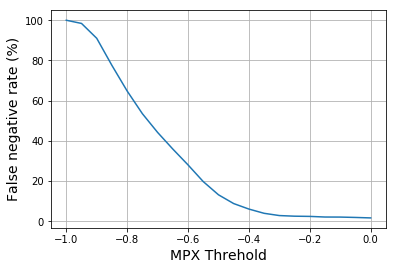

In [13]:
#missing rate for difernt xth
total_annots = len(x_annots)
res = []
for xth in np.arange(0, -1.01, -0.05):
    xa = (x_annots<xth).astype(int)    
    #print(np.sum(xa, axis=0))
    xa = np.amax(xa, axis=1)
    fn = total_annots - np.sum(xa)
    fnr = 100*fn/total
    res.append([xth, fnr])
    print([xth, fn, fnr])
    
res = np.array(res)
plt.plot(res[:, 0], res[:,1])
plt.ylabel('False negative rate (%)', fontsize=14)
plt.xlabel('MPX Threhold', fontsize=14)
plt.grid(True)
plt.show()
        

[0.0, 0.0, 64, 1.665799062988027]
[0.0, 0.1, 72, 1.8740239458615304]
[0.0, 0.2, 92, 2.3945861530452888]
[0.0, 0.3, 109, 2.8370640291514837]
[0.0, 0.4, 124, 3.2274856845393023]
[0.0, 0.5, 141, 3.6699635606454972]
[0.0, 0.6, 155, 4.034357105674128]
[0.0, 0.7, 175, 4.554919312857886]
[0.0, 0.8, 191, 4.971369078604893]
[0.0, 0.9, 199, 5.179593961478397]
[0.0, 1.0, 208, 5.413846954711088]
[0.0, 1.1, 219, 5.700156168662155]
[0.0, 1.2, 234, 6.090577824049974]
[0.0, 1.3, 244, 6.350858927641853]
[0.0, 1.4, 257, 6.689224362311296]
[0.0, 1.5, 280, 7.287870900572618]
[0.0, 1.6, 292, 7.6002082248828735]
[0.0, 1.7, 308, 8.01665799062988]
[0.0, 1.8, 321, 8.355023425299324]
[0.0, 1.9, 335, 8.719416970327954]
[0.0, 2.0, 353, 9.187922956793336]
[-0.1, 0.0, 80, 2.082248828735034]
[-0.1, 0.1, 87, 2.2644456012493492]
[-0.1, 0.2, 107, 2.785007808433108]
[-0.1, 0.3, 123, 3.2014575741801146]
[-0.1, 0.4, 138, 3.591879229567933]
[-0.1, 0.5, 155, 4.034357105674128]
[-0.1, 0.6, 169, 4.398750650702759]
[-0.1, 0.7,

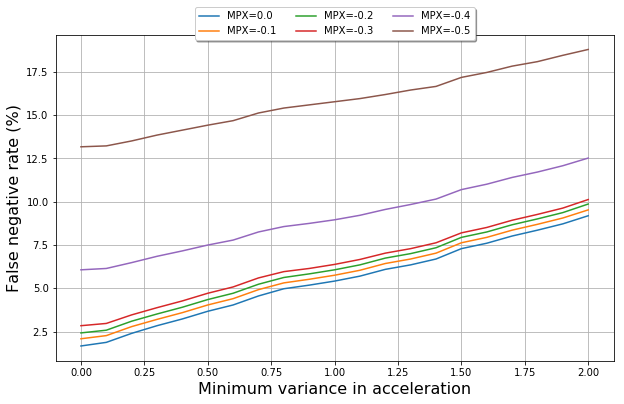

In [14]:
#missing rate for difernt var-th at some xth
fig = plt.figure(figsize=(10,6))
ax = plt.subplot(111)

total_annots = len(x_annots)
for xth in np.arange(0, -.51, -0.1):
    xth = int(xth*100)/100
    res = []
    for varth in np.arange(0, 2.05, 0.1):
        varth = int(varth*100)/100
        xa = (x_annots>xth)
        va = np.copy(var_annots)
        va[xa] = -1
        va = (va>=varth).astype(int)        
        va = np.amax(va, axis=1)
        
        fn = total_annots - np.sum(va)
        fnr = 100*fn/total
        res.append([varth, fnr])
        print([xth, varth, fn, fnr])
    
    
    res = np.array(res)
    ax.plot(res[:, 0], res[:,1], label='MPX='+str(xth))
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)

plt.ylabel('False negative rate (%)', fontsize=16)
plt.xlabel('Minimum variance in acceleration', fontsize=16)
plt.grid(True)
plt.show()
        

[0.0, 0.0, 47903]
[0.0, 0.1, 29906]
[0.0, 0.2, 26814]
[0.0, 0.3, 25008]
[0.0, 0.4, 23693]
[0.0, 0.5, 22667]
[0.0, 0.6, 21806]
[0.0, 0.7, 21078]
[0.0, 0.8, 20405]
[0.0, 0.9, 19856]
[0.0, 1.0, 19345]
[0.0, 1.1, 18892]
[0.0, 1.2, 18475]
[0.0, 1.3, 18139]
[0.0, 1.4, 17810]
[0.0, 1.5, 17539]
[0.0, 1.6, 17259]
[0.0, 1.7, 16979]
[0.0, 1.8, 16726]
[0.0, 1.9, 16492]
[0.0, 2.0, 16243]
[-0.1, 0.0, 34572]
[-0.1, 0.1, 23459]
[-0.1, 0.2, 21468]
[-0.1, 0.3, 20315]
[-0.1, 0.4, 19492]
[-0.1, 0.5, 18878]
[-0.1, 0.6, 18348]
[-0.1, 0.7, 17898]
[-0.1, 0.8, 17500]
[-0.1, 0.9, 17163]
[-0.1, 1.0, 16846]
[-0.1, 1.1, 16554]
[-0.1, 1.2, 16274]
[-0.1, 1.3, 16045]
[-0.1, 1.4, 15822]
[-0.1, 1.5, 15635]
[-0.1, 1.6, 15431]
[-0.1, 1.7, 15237]
[-0.1, 1.8, 15058]
[-0.1, 1.9, 14893]
[-0.1, 2.0, 14704]
[-0.2, 0.0, 27335]
[-0.2, 0.1, 18721]
[-0.2, 0.2, 17277]
[-0.2, 0.3, 16499]
[-0.2, 0.4, 15954]
[-0.2, 0.5, 15575]
[-0.2, 0.6, 15249]
[-0.2, 0.7, 14959]
[-0.2, 0.8, 14705]
[-0.2, 0.9, 14499]
[-0.2, 1.0, 14301]
[-0.2, 1.1, 14

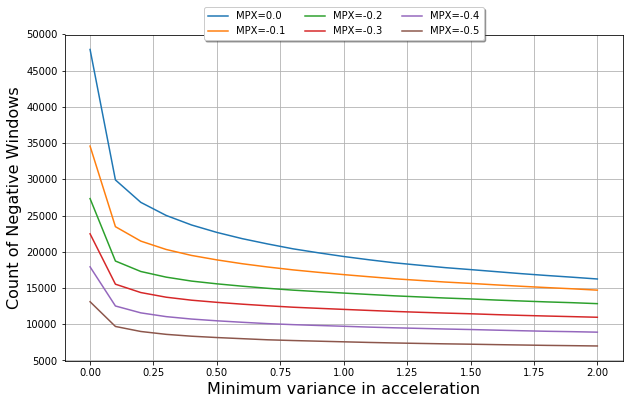

In [15]:
#negative count var-th at some xth

neg_cond = mp_covs[:, 0]==0
x_neg = x_var_mps[neg_cond, 0]
var_neg = x_var_mps[neg_cond, 1]

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for xth in np.arange(0, -.51, -0.1):
    xth = int(xth*100)/100
    res = []
    for varth in np.arange(0, 2.05, 0.1):
        varth = int(varth*100)/100
        cond = (x_neg<=xth) & (var_neg>=varth)
        count = np.sum(cond)
        res.append([varth, count])
        print([xth, varth, count])
    
    
    res = np.array(res)
    ax.plot(res[:, 0], res[:,1], label='MPX='+str(xth))
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)

plt.ylabel('Count of Negative Windows', fontsize=16)
plt.xlabel('Minimum variance in acceleration', fontsize=16)
plt.grid(True)
plt.show()
        

[0.0, 0.0, 4618]
[0.0, 0.1, 4597]
[0.0, 0.2, 4569]
[0.0, 0.3, 4545]
[0.0, 0.4, 4524]
[0.0, 0.5, 4502]
[0.0, 0.6, 4486]
[0.0, 0.7, 4464]
[0.0, 0.8, 4443]
[0.0, 0.9, 4429]
[0.0, 1.0, 4413]
[0.0, 1.1, 4393]
[0.0, 1.2, 4373]
[0.0, 1.3, 4355]
[0.0, 1.4, 4340]
[0.0, 1.5, 4314]
[0.0, 1.6, 4297]
[0.0, 1.7, 4273]
[0.0, 1.8, 4259]
[0.0, 1.9, 4243]
[0.0, 2.0, 4221]
[-0.1, 0.0, 4577]
[-0.1, 0.1, 4557]
[-0.1, 0.2, 4529]
[-0.1, 0.3, 4506]
[-0.1, 0.4, 4485]
[-0.1, 0.5, 4463]
[-0.1, 0.6, 4447]
[-0.1, 0.7, 4425]
[-0.1, 0.8, 4405]
[-0.1, 0.9, 4391]
[-0.1, 1.0, 4375]
[-0.1, 1.1, 4355]
[-0.1, 1.2, 4335]
[-0.1, 1.3, 4317]
[-0.1, 1.4, 4302]
[-0.1, 1.5, 4276]
[-0.1, 1.6, 4259]
[-0.1, 1.7, 4235]
[-0.1, 1.8, 4221]
[-0.1, 1.9, 4205]
[-0.1, 2.0, 4183]
[-0.2, 0.0, 4518]
[-0.2, 0.1, 4500]
[-0.2, 0.2, 4472]
[-0.2, 0.3, 4449]
[-0.2, 0.4, 4428]
[-0.2, 0.5, 4406]
[-0.2, 0.6, 4390]
[-0.2, 0.7, 4369]
[-0.2, 0.8, 4349]
[-0.2, 0.9, 4335]
[-0.2, 1.0, 4319]
[-0.2, 1.1, 4299]
[-0.2, 1.2, 4280]
[-0.2, 1.3, 4262]
[-0.2, 1.4, 4

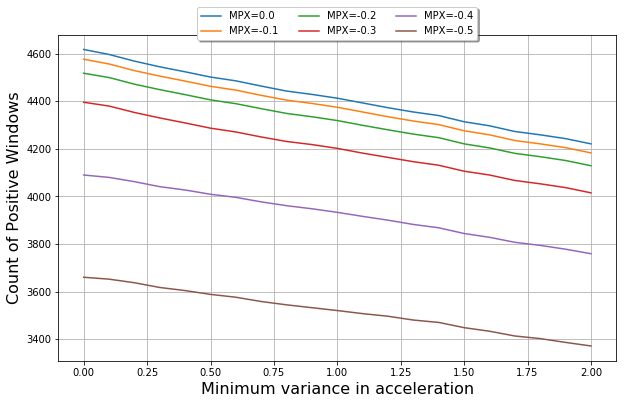

In [16]:
#positive count var-th at some xth
pos_cond = mp_covs[:, 0]>0
x_pos = x_var_mps[pos_cond, 0]
var_pos = x_var_mps[pos_cond, 1]

fig = plt.figure(figsize=(10, 6))
ax = plt.subplot(111)

for xth in np.arange(0, -.51, -0.1):
    xth = int(xth*100)/100
    res = []
    for varth in np.arange(0, 2.05, 0.1):
        varth = int(varth*100)/100
        cond = (x_pos<=xth) & (var_pos>=varth)
        count = np.sum(cond)
        res.append([varth, count])
        print([xth, varth, count])
    
    
    res = np.array(res)
    ax.plot(res[:, 0], res[:,1], label='MPX='+str(xth))
    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)

plt.ylabel('Count of Positive Windows', fontsize=16)
plt.xlabel('Minimum variance in acceleration', fontsize=16)
plt.grid(True)
plt.show()

In [17]:
gag = grav_accel_gyro_vals
grav = gag[:, :, 0:3]
accel = gag[:, :, 3:6].flatten()
gyro = gag[:, :, 6:].flatten()

#weights = np.ones_like(accel)/float(len(accel))
#plt.hist(accel, bins=100, weights=weights)
#plt.show()

#plt.hist(gyro, bins=100, weights=weights)
#plt.show()

print(len(accel))
print(np.sum((accel>19.6) | (accel<-19.6)))

print(len(gyro))
print(np.sum((accel>15) | (accel<-15)))




15126048
142
15126048
5813
